# Project 4: Graph Algorithms

## Part 1: Stock Market


In [1]:
library('igraph')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [96]:
company_ticker_list = read.csv("finance_data/Name_sector.csv",header=TRUE,stringsAsFactors=FALSE)
head(company_ticker_list,n = 15L)
print(sprintf("Number of companies in the ticker list is %s",nrow(company_ticker_list)))

,Symbol,Sector
,<chr>,<chr>
1,A,Health Care
2,AAL,Industrials
3,AAP,Consumer Discretionary
4,AAPL,Information Technology
5,ABBV,Health Care
6,ABC,Health Care
7,ABT,Health Care
8,ACN,Information Technology
9,ADBE,Information Technology


[1] "Number of companies in the ticker list is 505"


QUESTION 1: What are upper and lower bounds on $\rho_{ij}$? Provide a justification for using lognormalized return ($r_i(t)$) instead of regular return ($q_i(t)$).

$\rho_{ij}$ is in the range [-1,1]. Multiple advantages of using log-normal: a) normal distribution, b) small values are almost equal to raw values, c) Outl;iers are taken care of. Detailed explanation in the report. 

QUESTION 2: Plot a histogram showing the un-normalized distribution of edge weights

In [97]:
filenames <- list.files("finance_data/data/", pattern="*.csv")
filenames = paste("finance_data/data", filenames, sep="/")
print(sprintf("Number of companies in the ticker list is %s",length(filenames)))
comp_del=0
for(j in c(1:length(filenames))){
    comp_data = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    if(dim(comp_data)[1]!=765){
#         print(dim(df)[1])
        comp_del=comp_del+1
    }
}
print(sprintf("Number of companies in the ticker list with missing data: %s",comp_del))

[1] "Number of companies in the ticker list is 505"
[1] "Number of companies in the ticker list with missing data: 11"


In [98]:
# We ignore the 11 companies with incomplete data for easier calculation.
# step 1: Create a log_norm_returnrix of log-normalized return on stock i. 

i=1 # i is the ith stock 
log_norm_return = matrix(0,length(filenames)-comp_del,764)
num_data_points=c()
for(j in c(1:length(filenames))){
    comp_data = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    num_data_points[j] = dim(comp_data)[1]
    if(num_data_points[j]==765){
        p = comp_data[,5] # list of closing price
        q = c() # list of return of stock over a period of [t − 1, t]q[1] = p[1] # Assumption: gain from 0th day to 1st day is the closing price on first day.
        r = c()
        for(t in c(2:length(p))){
            q[t-1] = (p[t]-p[t-1])/p[t-1]
        }
        r = log(1+q)
        log_norm_return[i,] = r
        i = i+1
    }
}

In [99]:
# step 2a: Calculate edge weights for the correlation graph.

generate_correlation_weights= function(wt_file, log_norm_return,company_ticker_list){
    cat("from_node","\t","to_node","\t","edge_wt",file=wt_file)
    num_companies = dim(log_norm_return)[1]
    for(i in c(1:(num_companies-1))){
        for(j in c((i+1):num_companies)){
            r_i = mean(log_norm_return[i,])
            r_j = mean(log_norm_return[j,])
            r_ij = mean(log_norm_return[i,]*log_norm_return[j,])
            r_i_squared = log_norm_return[i,]^2
            r_j_squared = log_norm_return[j,]^2
            p_ij = (r_ij-(r_i*r_j))/(sqrt((mean(r_i_squared)-(r_i^2))*(mean(r_j_squared)-(r_j^2))))
#             print((sqrt((mean(r_i_squared)-(r_i^2))*(mean(r_j_squared)-(r_j^2)))))
            w_ij = sqrt(2*(1-p_ij))
            cat('\n',company_ticker_list[i,1],'\t',company_ticker_list[j,1],'\t',w_ij,file=wt_file)
        }
    }
}


# step 2b: Remove companies with incomplete data from ticker list:

comp_ignore=which(num_data_points!=765)
company_ticker_list=company_ticker_list[-comp_ignore,]



# step 2c: write the weights to a file to construct graph later. 

wt_file <- file("finance_data/edge_weights.txt", "w")
generate_correlation_weights(wt_file,log_norm_return,company_ticker_list)
close(wt_file)



,from_node,to_node,edge_wt
,<chr>,<chr>,<dbl>
1,A,AAL,1.189554
2,A,AAP,1.269710
3,A,AAPL,1.373192
4,A,ABBV,1.129386
5,A,ABC,1.248807
6,A,ABT,1.021796
7,A,ACN,1.055284
8,A,ADBE,1.098334
9,A,ADI,1.107646


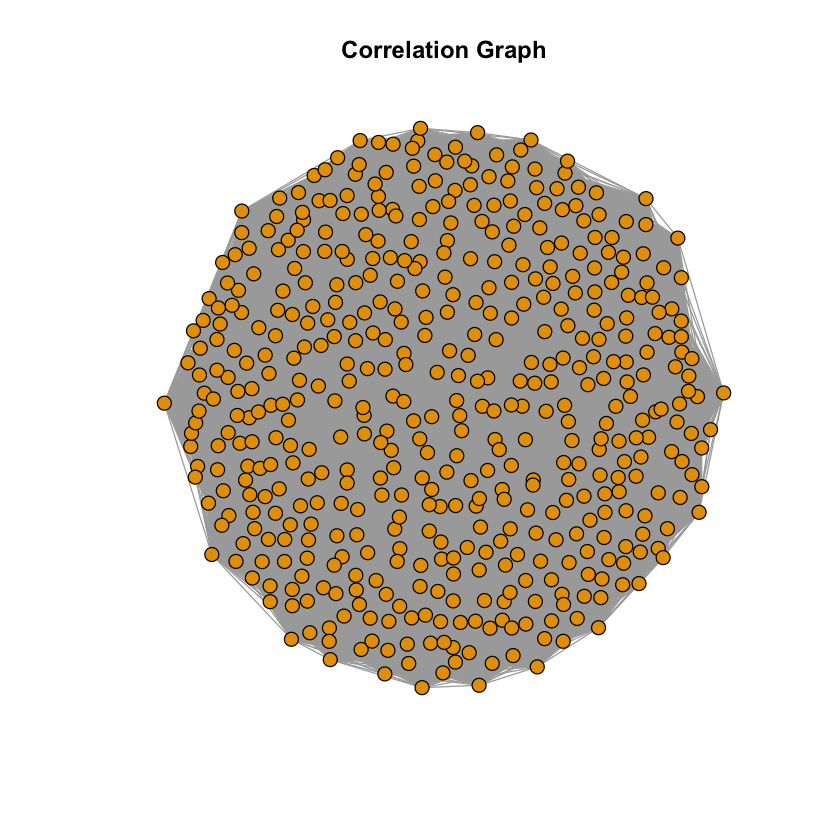

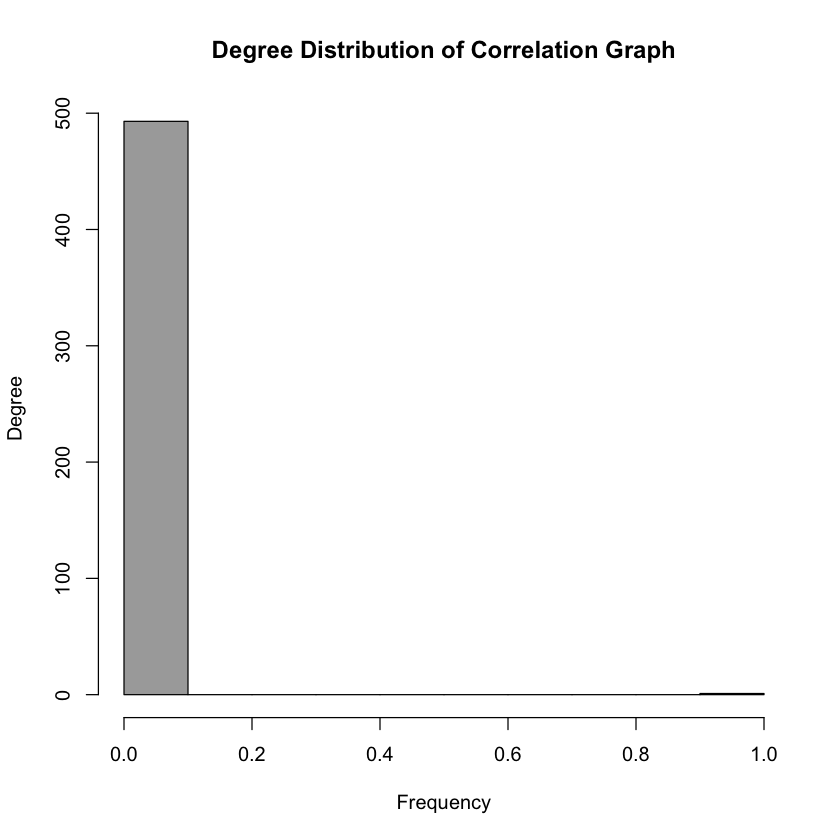

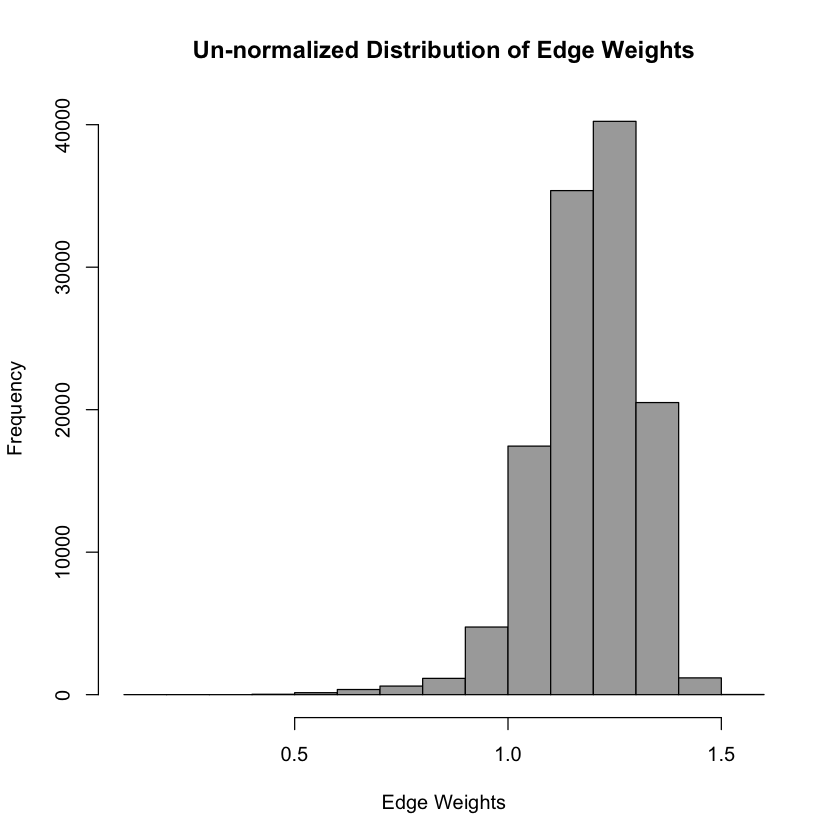

In [100]:
# step 3: Create a correlation graph with nodes as companies and edge weights as derived above. 

edge_list= read.delim("finance_data/edge_weights.txt",header=TRUE)
corr_graph = graph.data.frame(edge_list, directed = FALSE)
E(corr_graph)$weight = edge_list[,"edge_wt"]


# step 4: plot histogram and other data analyis outputs. 
head(edge_list,n = 15L)
plot(corr_graph, vertex.label="", vertex.size=5,main="Correlation Graph")
hist(degree.distribution(corr_graph),col="darkgrey",main="Degree Distribution of Correlation Graph", ylab="Degree",xlab="Frequency")
hist(edge_list[,"edge_wt"],col="darkgrey",main="Un-normalized Distribution of Edge Weights",xlab="Edge Weights",ylab="Frequency")


QUESTION 3: Extract the MST of the correlation graph. Each stock can be categorized into
a sector, which can be found in Name sector.csv file. Plot the MST and color-code the nodes
based on sectors. Do you see any pattern in the MST? The structures that you find in MST are
called Vine clusters. Provide a detailed explanation about the pattern you observe.

In [101]:
# Find the number of sectors. 

comp_sectors = unique(company_ticker_list[,2])
print(sprintf("Number of unique sectors: %s" , length(comp_sectors)))
sprintf(comp_sectors)

[1] "Number of unique sectors: 11"


[1] "Health Care"                "Industrials"               
 [3] "Consumer Discretionary"     "Information Technology"    
 [5] "Consumer Staples"           "Utilities"                 
 [7] "Financials"                 "Real Estate"               
 [9] "Materials"                  "Energy"                    
[11] "Telecommunication Services"

In [117]:
min_span_tree = mst(corr_graph,algorithm="prim")
min_span_tree
print(sprintf("Number of edges in the minimum spanning tree is : %s", ecount(min_span_tree)))
print(sprintf("Number of Vertices in the minimum spanning tree is : %s", vcount(min_span_tree)))

IGRAPH e1d19da UNW- 494 493 -- 
+ attr: name (v/c), color (v/c), edge_wt (e/n), weight (e/n)
+ edges from e1d19da (vertex names):
 [1]  A    -- TMO    AAL  -- DAL    AAP  -- ORLY   AAPL -- UNP    ABBV -- AMGN 
 [6]  ABC  -- CAH    ABT  -- HOLX   ABT  -- MDT    ABT  -- TMO    ABT  -- VAR  
[11]  ACN  -- CTSH   ACN  -- FISV   ACN  -- ORCL   ACN  -- RHT    ADBE -- CRM  
[16]  ADBE -- INTU   ADI  -- TXN    ADI  -- XLNX   ADM  -- PFG    ADP  -- PAYX 
[21]  ADS  -- DFS    ADSK -- MCO    AEE  -- XEL    AEP  -- DUK    AEP  -- ETR  
[26]  AEP  -- FE     AEP  -- PPL    AEP  -- XEL    AES  -- CNP    AES  -- NRG  
[31]  AET  -- ANTM   AET  -- CNC    AET  -- HUM    AET  -- UNH    AFL  -- PRU  
[36]  AGN  -- AMGN   AGN  -- MYL    AIG  -- JPM    AIV  -- REG    AIV  -- UDR  
+ ... omitted several edges

[1] "Number of edges in the minimum spanning tree is : 493"
[1] "Number of Vertices in the minimum spanning tree is : 494"


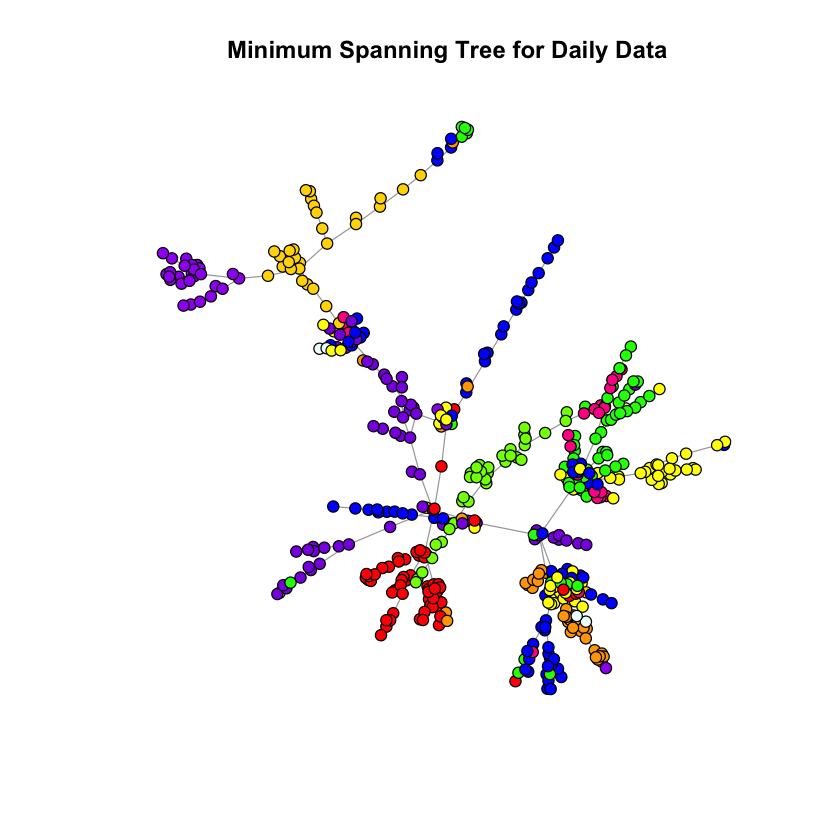

In [125]:
sector_colors = list("Health Care"="red",
              "Industrials"="green",
              "Consumer Discretionary"="blue",
              "Information Technology"="yellow",
              "Consumer Staples"="orange",
              "Utilities"="purple",
              "Financials"="blueviolet",
              "Real Estate"="gold",
              "Materials"="deeppink",
              "Energy"="chartreuse",
              "Telecommunication Services"="azure")

sector_color_mapping = function(corr_graph,company_ticker_list, sector_colors){
    color_map = c()
    for(v in c(1:vcount(corr_graph))){
        sector = company_ticker_list[v,2]
        color_map[v] = sector_colors[[sector]]
    }
    return(color_map)
}

color_map = sector_color_mapping(corr_graph,company_ticker_list,sector_colors)
plot(min_span_tree,vertex.size=4, vertex.label=NA, vertex.color=color_map, main=" Minimum Spanning Tree for Daily Data")

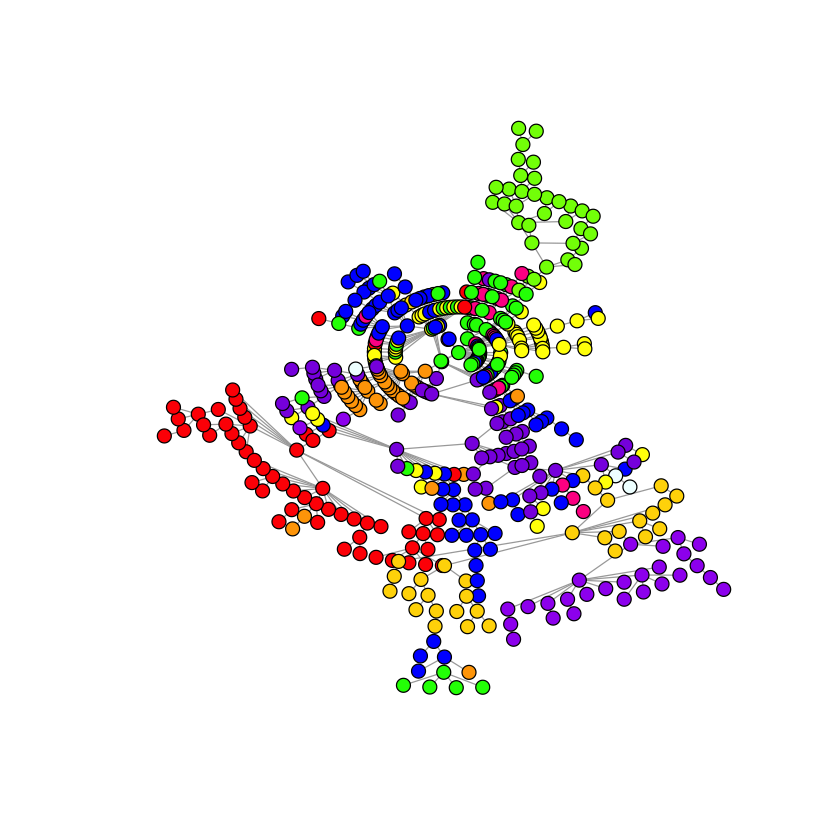

In [126]:
plot(min_span_tree,vertex.size=5, vertex.label=NA, vertex.color=color_map, layout=layout.reingold.tilford(min_span_tree,circular=T))

QUESTION 4: Report the value of $\alpha$ for the above two cases and provide an interpretation for
the difference.

In [129]:
# Find the value of S_i for all i: The number of memebver in each community. 
S_i = c()
print("Number of nodes belonging each Sector")
for(i in c(1:length(comp_sectors))){
    S_i[i] = length(which(company_ticker_list[,2]==comp_sectors[i]))
    print(sprintf("%s: %s", comp_sectors[i], S_i[i]))
}

# find alpha for 
p_method_1 = c()
p_method_2 = c()
for(v in c(1:vcount(min_span_tree))){
    neighbors_v = neighbors(min_span_tree,v)
    N_i = length(neighbors_v)
    Q_i=0
    for(i in neighbors_v){
        if(company_ticker_list[i,2]==company_ticker_list[v,2])
            Q_i=Q_i+1
    }
    p_method_1[v] = Q_i/N_i
    p_method_2[v] = S_i[which(comp_sectors==company_ticker_list[v,2])]/vcount(min_span_tree)
}
alpha_1 = sum(p_method_1)/vcount(min_span_tree)
print(sprintf("Alpha value for method 1 is: %s",alpha_1))
alpha_2 = sum(p_method_2)/vcount(min_span_tree)
print(sprintf("Alpha value for method 2 is: %s",alpha_2))

[1] "Number of nodes belonging each Sector"
[1] "Health Care: 60"
[1] "Industrials: 64"
[1] "Consumer Discretionary: 84"
[1] "Information Technology: 66"
[1] "Consumer Staples: 36"
[1] "Utilities: 28"
[1] "Financials: 63"
[1] "Real Estate: 31"
[1] "Materials: 24"
[1] "Energy: 34"
[1] "Telecommunication Services: 4"
[1] "Alpha value for method 1 is: 0.828930077530676"
[1] "Alpha value for method 2 is: 0.114188070612533"


QUESTION 5: Extract the MST from the correlation graph based on weekly data. Compare the
pattern of this MST with the pattern of the MST found in Question 3.

In [133]:
# Repeating Q2,Q3 and Q4. 
company_ticker_list_week = read.csv("finance_data/Name_sector.csv",header=TRUE,stringsAsFactors=FALSE)
filenames_week <- list.files("finance_data/data/", pattern="*.csv")
filenames_week = paste("finance_data/data", filenames_week, sep="/")
print(sprintf("Number of companies in the ticker list is %s",length(filenames_week)))
comp_del_week=0
for(j in c(1:length(filenames_week))){
    comp_data_week = read.csv(filenames_week[j],header=TRUE, stringsAsFactors=FALSE)
    comp_data_week["Day"]=weekdays(as.Date(comp_data_week[,1])) 
    comp_data_week =subset(comp_data_week, Day=='Monday')
    if(dim(comp_data_week)[1]!=143){
#         print(dim(df)[1])
        comp_del_week=comp_del_week+1
    }
}
print(sprintf("Number of companies in the ticker list with missing data for Mondays: %s",comp_del_week))

[1] "Number of companies in the ticker list is 505"
[1] "Number of companies in the ticker list with missing data for Mondays: 13"


,from_node,to_node,edge_wt
,<chr>,<chr>,<dbl>
1,A,AAL,1.199583
2,A,AAP,1.260472
3,A,AAPL,1.426122
4,A,ABBV,1.110045
5,A,ABC,1.230741
6,A,ABT,1.005328
7,A,ACN,1.045794
8,A,ADBE,1.051711
9,A,ADI,1.122624


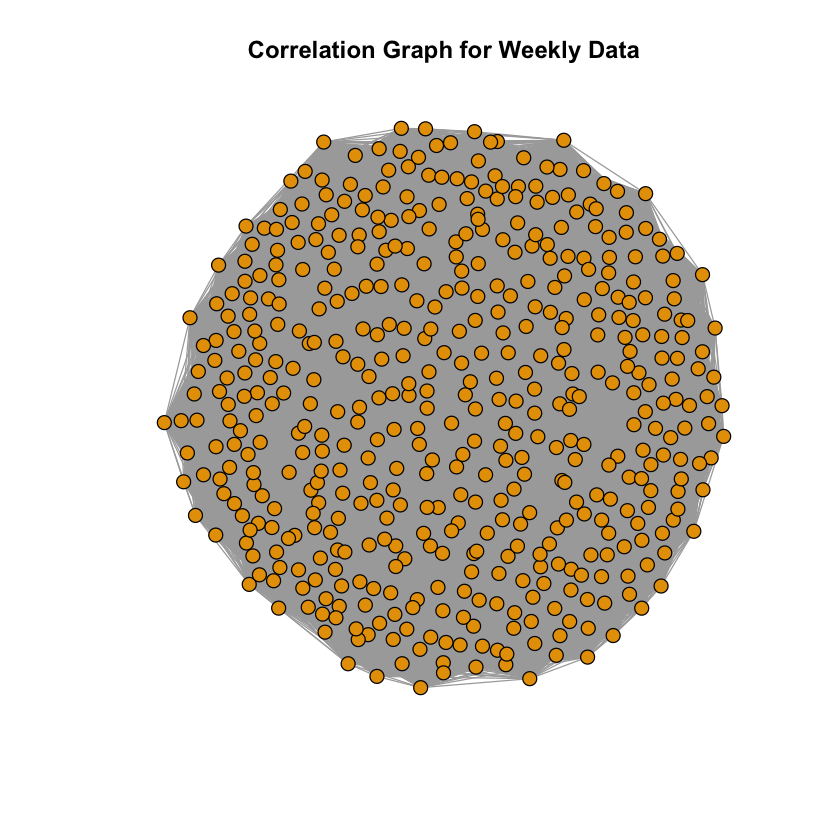

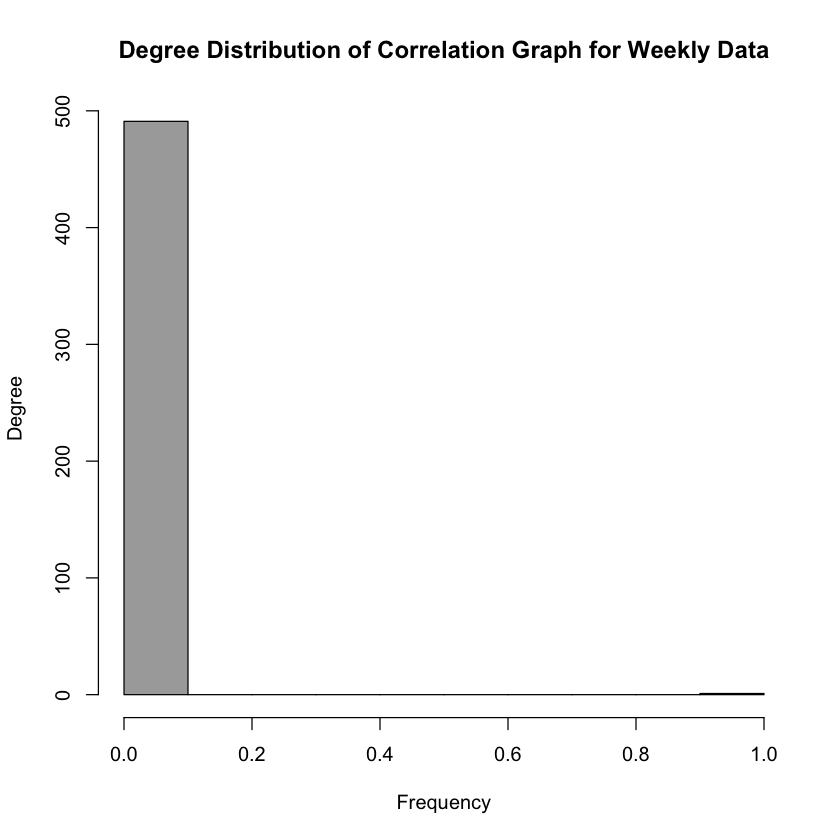

[1] "Number of unique sectors: 11"


[1] "Health Care"                "Industrials"               
 [3] "Consumer Discretionary"     "Information Technology"    
 [5] "Consumer Staples"           "Utilities"                 
 [7] "Financials"                 "Real Estate"               
 [9] "Materials"                  "Energy"                    
[11] "Telecommunication Services"

IGRAPH fa6d6ba UNW- 492 491 -- 
+ attr: name (v/c), edge_wt (e/n), weight (e/n)
+ edges from fa6d6ba (vertex names):
 [1]  A    -- TMO    AAL  -- DAL    AAL  -- IPG    AAL  -- UAL    AAP  -- AZO  
 [6]  AAPL -- UNP    ABBV -- AMGN   ABBV -- MYL    ABC  -- CAH    ABT  -- AMGN 
[11]  ABT  -- HOLX   ABT  -- TMO    ACN  -- CTSH   ACN  -- FISV   ACN  -- MCD  
[16]  ACN  -- RHT    ADBE -- AMZN   ADBE -- CCL    ADBE -- CRM    ADBE -- EFX  
[21]  ADBE -- EQIX   ADBE -- MA     ADI  -- TXN    ADM  -- PFG    ADP  -- PAYX 
[26]  ADS  -- DAL    ADSK -- CSCO   AEE  -- XEL    AEP  -- AWK    AEP  -- ETR  
[31]  AEP  -- FE     AEP  -- O      AEP  -- PCG    AEP  -- PEG    AEP  -- SO   
[36]  AEP  -- XEL    AES  -- CNP    AET  -- CI     AET  -- HUM    AET  -- UNH  
+ ... omitted several edges

[1] "Number of edges in the minimum spanning tree for Weekely Data is : 491"
[1] "Number of Vertices in the minimum spanning tree for Weekely Data is : 492"


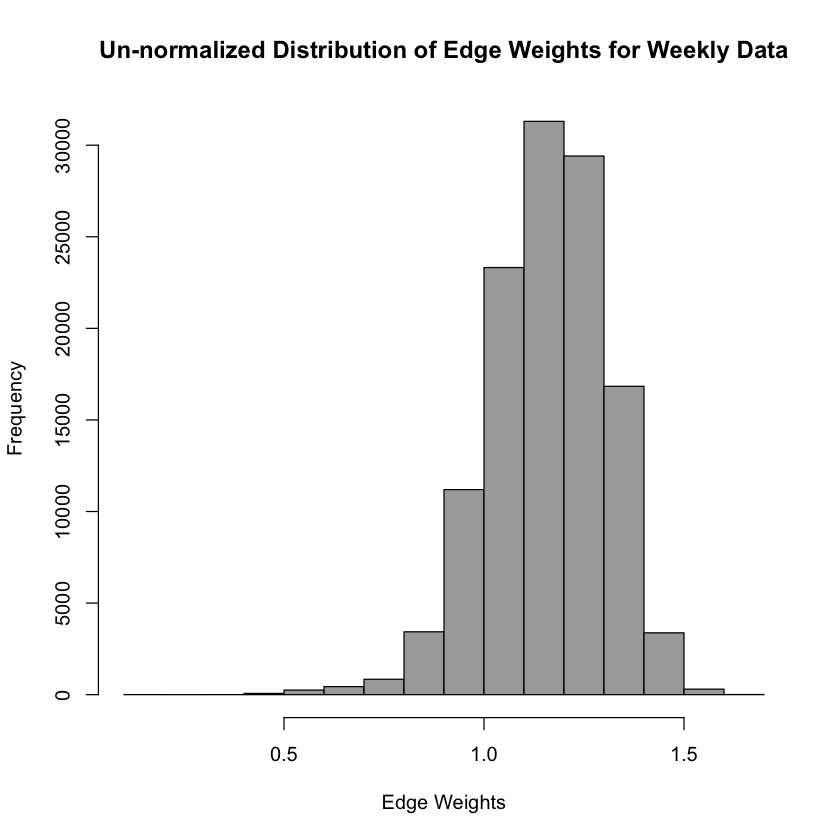

In [134]:
# We ignore the 13 companies with incomplete data for easier calculation.
# step 1: Create a log_norm_return matrix of log-normalized weekly return on stock i. 

i=1 # i is the ith stock 
log_norm_return_week = matrix(0,length(filenames_week)-comp_del_week,142)
num_data_points_week=c()
for(j in c(1:length(filenames_week))){
    comp_data_week = read.csv(filenames_week[j],header=TRUE, stringsAsFactors=FALSE)
    comp_data_week["Day"]=weekdays(as.Date(comp_data_week[,1])) 
    comp_data_week =subset(comp_data_week, Day=='Monday')
    num_data_points_week[j] = dim(comp_data_week)[1]
    if(num_data_points_week[j]==143){
        p_week = comp_data_week[,5] # list of closing price
        q_week = c() # list of return of stock over a period of [t − 1, t]q[1] = p[1]
        r_week = c()
        for(t in c(2:length(p_week))){
            q_week[t-1] = (p_week[t]-p_week[t-1])/p_week[t-1]
        }
        r_week = log(1+q_week)
        log_norm_return_week[i,] = r_week
        i = i+1
    }
}



# step 2b: Remove companies with incomplete data from ticker list:

comp_ignore_week=which(num_data_points_week!=143)
company_ticker_list_week=company_ticker_list_week[-comp_ignore_week,]



# step 2c: write the weights to a file to construct graph later. 

wt_file_week = file("finance_data/edge_weights_week.txt", "w")
generate_correlation_weights(wt_file_week,log_norm_return_week,company_ticker_list_week)
close(wt_file_week)

# step 3: Create a correlation graph with nodes as companies and edge weights as derived above. 

edge_list_week= read.delim("finance_data/edge_weights_week.txt",header=TRUE)
corr_graph_week = graph.data.frame(edge_list_week, directed = FALSE)
E(corr_graph_week)$weight = edge_list_week[,"edge_wt"]


# step 4: plot histogram and other data analyis outputs. 
head(edge_list_week,n = 15L)
plot(corr_graph_week, vertex.label="", vertex.size=5,main="Correlation Graph for Weekly Data")
hist(degree.distribution(corr_graph_week),col="darkgrey",main="Degree Distribution of Correlation Graph for Weekly Data", ylab="Degree",xlab="Frequency")
hist(edge_list_week[,"edge_wt"],col="darkgrey",main="Un-normalized Distribution of Edge Weights for Weekly Data",xlab="Edge Weights",ylab="Frequency")


# Find the number of sectors. 

comp_sectors_week = unique(company_ticker_list_week[,2])
print(sprintf("Number of unique sectors: %s" , length(comp_sectors_week)))
sprintf(comp_sectors_week)


# Extract the MST

min_span_tree_week = mst(corr_graph_week,algorithm="prim")
min_span_tree_week
print(sprintf("Number of edges in the minimum spanning tree for Weekely Data is : %s", ecount(min_span_tree_week)))
print(sprintf("Number of Vertices in the minimum spanning tree for Weekely Data is : %s", vcount(min_span_tree_week)))

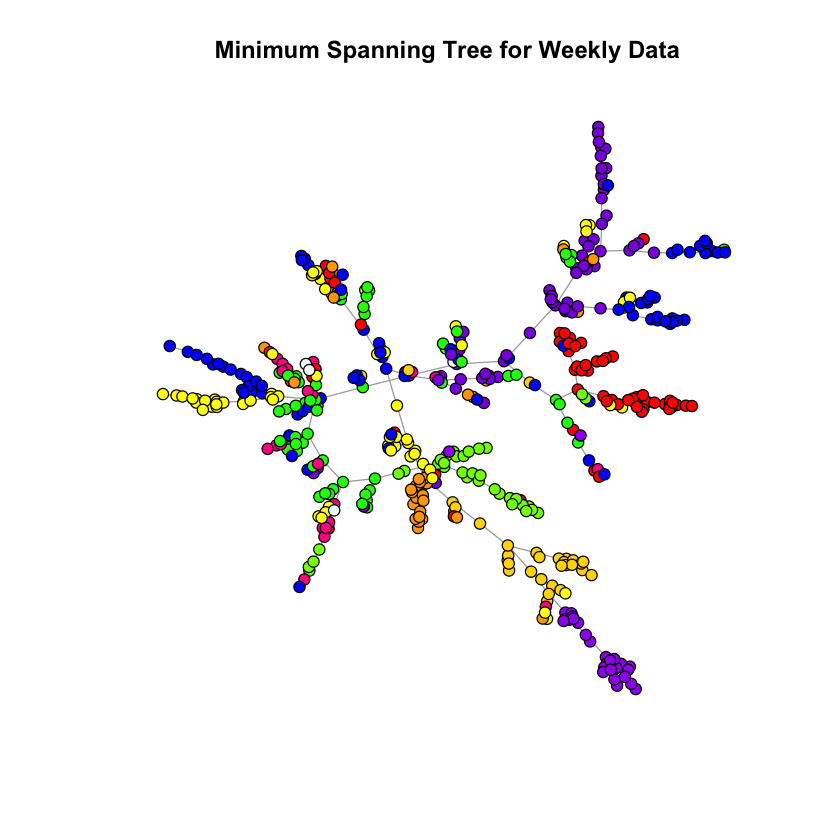

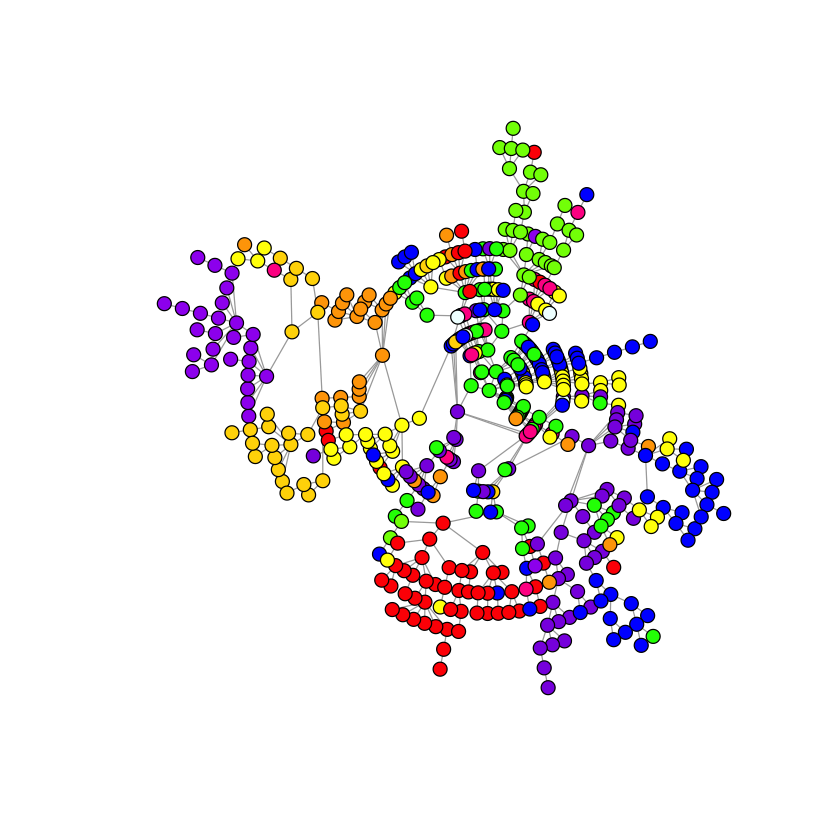

In [135]:
color_map_week = sector_color_mapping(corr_graph_week,company_ticker_list_week,sector_colors)
plot(min_span_tree_week,vertex.size=4, vertex.label=NA, vertex.color=color_map_week, main=" Minimum Spanning Tree for Weekly Data")
plot(min_span_tree_week,vertex.size=5, vertex.label=NA, vertex.color=color_map_week, layout=layout.reingold.tilford(min_span_tree_week,circular=T))

In [136]:
# Find the value of S_i for all i: The number of memebver in each community. 
S_i_week = c()
print("Number of nodes belonging each Sector")
for(i in c(1:length(comp_sectors_week))){
    S_i_week[i] = length(which(company_ticker_list_week[,2]==comp_sectors_week[i]))
    print(sprintf("%s: %s", comp_sectors_week[i], S_i_week[i]))
}

# find alpha for 
p_method_1_week = c()
p_method_2_week = c()
for(v in c(1:vcount(min_span_tree_week))){
    neighbors_v_week = neighbors(min_span_tree_week,v)
    N_i_week = length(neighbors_v_week)
    Q_i_week=0
    for(i in neighbors_v_week){
        if(company_ticker_list_week[i,2]==company_ticker_list_week[v,2])
            Q_i_week=Q_i_week+1
    }
    p_method_1_week[v] = Q_i_week/N_i_week
    p_method_2_week[v] = S_i_week[which(comp_sectors_week==company_ticker_list_week[v,2])]/vcount(min_span_tree_week)
}
alpha_1_week = sum(p_method_1_week)/vcount(min_span_tree_week)
print(sprintf("Alpha value for method 1 with weekly data is: %s",alpha_1_week))
alpha_2_week = sum(p_method_2_week)/vcount(min_span_tree_week)
print(sprintf("Alpha value for method 2 with weekly data is: %s",alpha_2_week))

[1] "Number of nodes belonging each Sector"
[1] "Health Care: 60"
[1] "Industrials: 64"
[1] "Consumer Discretionary: 84"
[1] "Information Technology: 66"
[1] "Consumer Staples: 35"
[1] "Utilities: 28"
[1] "Financials: 62"
[1] "Real Estate: 31"
[1] "Materials: 24"
[1] "Energy: 34"
[1] "Telecommunication Services: 4"
[1] "Alpha value for method 1 with weekly data is: 0.743957284810943"
[1] "Alpha value for method 2 with weekly data is: 0.114308612598321"
